[*********************100%%**********************]  1 of 1 completed


Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 613ms/step - loss: 0.2782 - mean_squared_error: 0.2782 - val_loss: 0.1336 - val_mean_squared_error: 0.1336
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0822 - mean_squared_error: 0.0822 - val_loss: 0.0621 - val_mean_squared_error: 0.0621
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0258 - mean_squared_error: 0.0258 - val_loss: 0.0234 - val_mean_squared_error: 0.0234
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0260 - mean_squared_error: 0.0260 - val_loss: 0.0215 - val_mean_squared_error: 0.0215
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0186 - val_mean_squared_error: 0.0186
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0192 - mean_squared_error: 0.0192 - val_loss: 0.0196 - val_mean_squared_error: 0.0196
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 386ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/

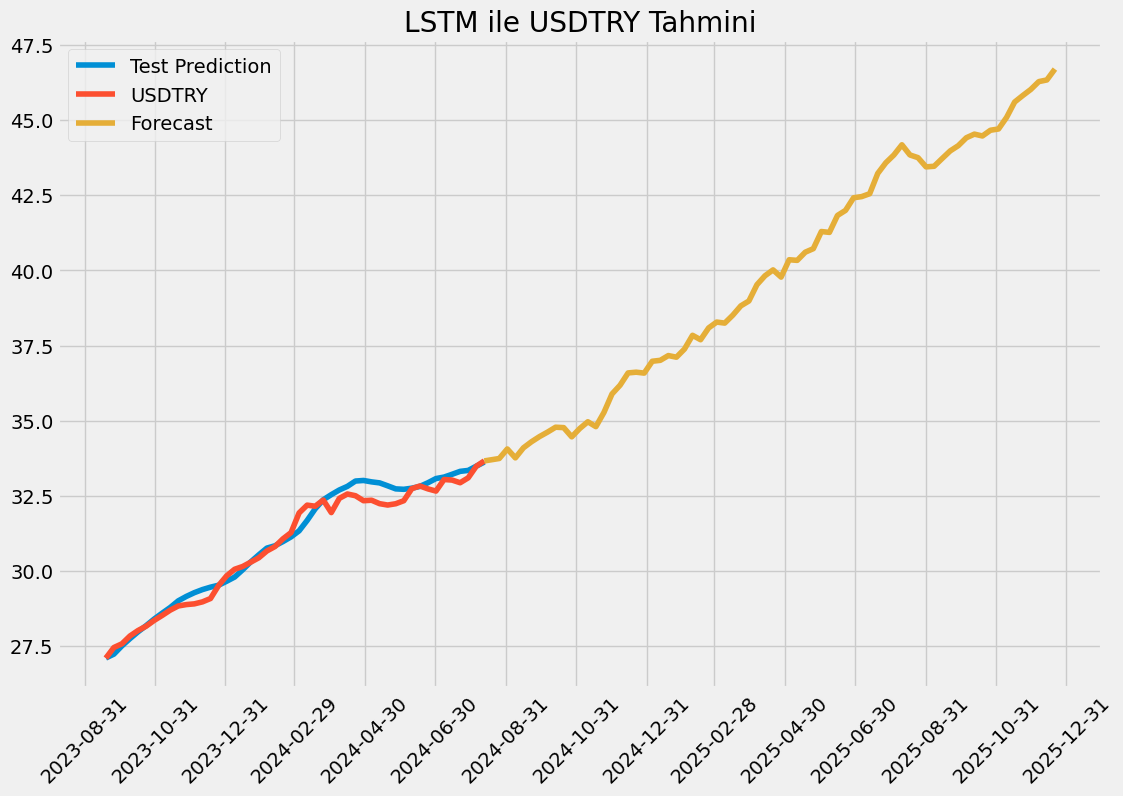

In [15]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,GRU,SimpleRNN
import keras
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2,l1
from keras.layers import Bidirectional
import random
import math
import yfinance as yf
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
data=yf.download(tickers="USDTRY=X",interval="1wk",start="2018-01-01")
data1=data[["Open","High","Low","Close"]]
scaler=StandardScaler()
scaled_data=scaler.fit_transform(np.array(data1.iloc[:,:-1]))
scaler2=StandardScaler()
scaled_y=scaler2.fit_transform(np.array(data1["Close"]).reshape(-1,1))
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaled_data["Close"]=scaled_y
    

def ts(data,timestep,fs):
    X,y=[],[]
    for i in range(timestep,len(data)-fs+1):
            X.append(data.iloc[i-timestep:i,:-1])
            y.append(data.iloc[i:i+fs,-1])
    return np.array(X),np.array(y)
    
timestep=4
forecast=1
train=scaled_data[:-56]
test=scaled_data[-56:]


X_train,y_train=ts(train,timestep,forecast)
X_test,y_test=ts(test,timestep,forecast)
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],3)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],3)


    
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Bidirectional(LSTM(69,activation="tanh",input_shape=(X_train.shape[1],X_train.shape[2]))))
model.add(Dropout(0.24524916945054973))

model.add(Dense(y_train.shape[1]))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.017998656219232065)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
model.fit(X_train, y_train, epochs=1000, batch_size=89,callbacks=[early_stopping],verbose=1,validation_split=0.1)

tahminler=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler.columns=["USDTRY"]
tahminler["Tahmin"]=scaler2.inverse_transform(model.predict(X_test))
tahminler=tahminler.set_index(pd.to_datetime(data.index[-52:]))


list=scaler2.inverse_transform((model.predict(X_test))[:,0].reshape(-1,1))[:,0].tolist()

for i in range(70):
    std=data["Open"].rolling(4).std()[-1]
    openkat=math.log(data["Open"].rolling(4).mean()[-1],data["Close"].rolling(4).mean()[-1])
    highkat=math.log(data["High"].rolling(4).mean()[-1],data["Close"].rolling(4).mean()[-1])
    lowkat=math.log(data["Low"].rolling(4).mean()[-1],data["Close"].rolling(4).mean()[-1])
    list.append(scaler2.inverse_transform(model.predict(np.array(scaled_data.iloc[-timestep:,:-1]).reshape(1,timestep,3)))[0][0])
    opens=random.uniform(0-10*std,0+10*std)+(list[-1]**openkat)
    highs=random.uniform(0-10*std,0+10*std)+(list[-1]**highkat)
    lows=random.uniform(0-2*std,0+2*std)+(list[-1]**lowkat)
    next=pd.DataFrame({"Open":opens,"High":highs,"Low":lows,"Close":list[-1]},index=[pd.to_datetime(pd.date_range(start="2024-08-19",freq="W",periods=70)[i])])
    data1=pd.concat([data1,next],axis=0)
    scaler=StandardScaler()
    scaled_data=scaler.fit_transform(np.array(data1.iloc[:,:-1]))
    scaler2=StandardScaler()
    scaled_y=scaler2.fit_transform(np.array(data1["Close"]).reshape(-1,1))
    scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
    scaled_data["Close"]=scaled_y




plt.style.use("fivethirtyeight")
plt.figure(figsize=(12,8))
plt.title("LSTM ile USDTRY Tahmini")
plt.plot(tahminler["Tahmin"][4:],label="Test Prediction")
plt.plot(tahminler["USDTRY"][4:],label="USDTRY")
plt.plot(data1["Close"][-71:],"-",label="Forecast")
plt.xticks(data1.resample('M').mean().index[-29::2],rotation=45)
plt.legend()
